In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy import interpolate
from datetime import datetime

In [54]:
# Deterministic
lowquality = 0             # 0 = High, 1 = Low
crest_height = 8.40
y_f = 1
g = 9.81
fetch = [2392,3128,3480,2992,1622,738,240,120,120,176,750,2002,2848,3084,2574,1762]
angle = [10.5,33,55.5,78,100.5,123,145.5,168,-169.5,-147,-124.5,-102,-79.5,-57,-34.5,-12]
winddir = ["NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW", "N"]
revetment = [[225,250],[100,120],[70,80],[40,50]]

In [55]:
# Load distributions
# Water level
data = np.loadtxt('Cumulative_density_function_water_level.txt', delimiter=' ', unpack=True)

# Wind
df = pd.read_excel (r'exc_wind.xlsx')
exc_vel = df["Wind velocity [m/s] "].tolist()
exc_wind = []

for i in range(16):
    exc_wind.append(1 - np.array(df[winddir[i]].tolist()))

In [67]:
iterations = 116
n = 1000000

Pf = []

for k in range(iterations):
    fail = 0

    for i in range(n):    
        # Generate a random wind direction
        j = random.choices([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],[6.4,10.4,14.5,10.3,1.9,2.3,2.2,2.8,4.5,4.9,4.1,2.2,13.9,10.5,6.0,3.1])[0]

        # Generate a random wind speed
        w = random.random()
        u = np.interp(w, exc_wind[j], exc_vel)

        # Calculate y_beta
        y_beta = 1 - 0.0033 * np.absolute(angle[j])
        if(np.absolute(angle[j]) > 80):
            y_beta = 1 - 0.0033 * 80

        # Generate water height, Rc and d
        #w = random.random();
        b = random.normalvariate(2.35, 0.3);
        swl = np.interp(w, data[1], data[0])
        Rc = crest_height - swl
        d = swl - b

        # If there is no water depth, there is no failure
        if(d < 0):
            continue

        # Calculate wave height
        F = (fetch[j] * g) / u**2
        D = (d * g) / u**2
        Hdak = 0.283 * np.tanh(0.53 * D**0.75) * np.tanh((0.0125 * F**0.42)/(np.tanh(0.53 * D**0.75)))
        H = (Hdak * u**2) / g

        # Angle checks and reductions
        if(np.absolute(angle[j]) > 110):
            H = 0
        elif(np.absolute(angle[j]) > 80):
            H = H * (110 - np.absolute(angle[j])) / 30
            if(H < 0):
                H = 0

        # Grass cover quality
        if(H > 2):
            wavecat = 2
        elif(H > 1):
            wavecat = 1
        else:
            wavecat = 0
        index = lowquality+wavecat
        sigma = (np.log(1 + (revetment[index][1]/revetment[index][0])**2))**0.5
        mu = np.log(revetment[index][0]) - 0.5 * sigma**2
        q = np.random.lognormal(mu, sigma);
        
        # Check for overflow, if there is overflow, count it as a fail and continue the loop
        if(Rc < 0):
            qov = 0.54 * ((9.81 * np.absolute(Rc ** 3)) ** 0.5) * (10 ** 3)
            if(qov > q):
                fail += 1
            continue

        # Calculate exponents
        a = 0.09;
        b = 1.5;

        # Z = R - S
        Z = 1
        if(H > 0):
            Z = q - 10**3 * a * np.exp(-(((b * Rc) / (H * y_f * y_beta))**1.3)) * ((g * H**3)**0.5)

        if(Z < 0):
            fail += 1

    Pf.append(fail / n)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(str(k) + "|" + str(current_time) + "|" + str(fail) + "|" + str(Pf[k]) + "|" + str(round(1/Pf[k],2)) + "|" + str(np.sum(Pf) / (k+1)))
print("\n\nTOTAL:")
print("Pf", np.sum(Pf) / (iterations))
print("RP: 1 in", round(1/(np.sum(Pf) / (iterations)),2), "years")

0|16:10:37|19|1.9e-05|52631.58|1.9e-05
1|16:11:56|22|2.2e-05|45454.55|2.05e-05
2|16:13:12|22|2.2e-05|45454.55|2.1e-05
3|16:14:29|20|2e-05|50000.0|2.075e-05
4|16:15:45|33|3.3e-05|30303.03|2.32e-05
5|16:17:00|27|2.7e-05|37037.04|2.3833333333333334e-05
6|16:18:15|25|2.5e-05|40000.0|2.4000000000000004e-05
7|16:19:29|30|3e-05|33333.33|2.4750000000000002e-05
8|16:20:44|18|1.8e-05|55555.56|2.4e-05
9|16:21:58|25|2.5e-05|40000.0|2.4100000000000003e-05
10|16:23:14|26|2.6e-05|38461.54|2.4272727272727275e-05
11|16:24:29|34|3.4e-05|29411.76|2.5083333333333338e-05
12|16:25:43|24|2.4e-05|41666.67|2.5000000000000005e-05
13|16:27:01|23|2.3e-05|43478.26|2.4857142857142863e-05
14|16:28:17|31|3.1e-05|32258.06|2.526666666666667e-05
15|16:29:32|21|2.1e-05|47619.05|2.5e-05
16|16:30:47|23|2.3e-05|43478.26|2.488235294117647e-05
17|16:32:09|22|2.2e-05|45454.55|2.4722222222222223e-05
18|16:33:26|20|2e-05|50000.0|2.4473684210526318e-05
19|16:34:43|19|1.9e-05|52631.58|2.4200000000000002e-05
20|16:35:59|24|2.4e-05|

In [68]:
Pf

[1.9e-05,
 2.2e-05,
 2.2e-05,
 2e-05,
 3.3e-05,
 2.7e-05,
 2.5e-05,
 3e-05,
 1.8e-05,
 2.5e-05,
 2.6e-05,
 3.4e-05,
 2.4e-05,
 2.3e-05,
 3.1e-05,
 2.1e-05,
 2.3e-05,
 2.2e-05,
 2e-05,
 1.9e-05,
 2.4e-05,
 2.7e-05,
 2.9e-05,
 3.6e-05,
 2.3e-05,
 2.1e-05,
 1.4e-05,
 2.3e-05,
 1.4e-05,
 2.5e-05,
 3e-05,
 2.8e-05,
 1.6e-05,
 2.4e-05,
 1.5e-05,
 2.3e-05,
 1.7e-05,
 2.2e-05,
 2.1e-05,
 2.4e-05,
 1.3e-05,
 2.5e-05,
 2.2e-05,
 2.6e-05,
 1.9e-05,
 2.2e-05,
 2.7e-05,
 2.8e-05,
 2e-05,
 2e-05,
 2.1e-05,
 2.4e-05,
 1.9e-05,
 1.9e-05,
 3.2e-05,
 2.7e-05,
 2.7e-05,
 3.3e-05,
 2.6e-05,
 2.8e-05,
 2.4e-05,
 2.1e-05,
 2.7e-05,
 2.2e-05,
 1.9e-05,
 2e-05,
 2.2e-05,
 2e-05,
 2.1e-05,
 3.1e-05,
 1.9e-05,
 2.6e-05,
 1.8e-05,
 2.5e-05,
 1.3e-05,
 1.6e-05,
 2e-05,
 2.5e-05,
 2e-05,
 2.1e-05,
 2.2e-05,
 2.1e-05,
 2e-05,
 2.3e-05,
 2e-05,
 1.7e-05,
 1.8e-05,
 2.4e-05,
 2.5e-05,
 2.2e-05,
 1.9e-05,
 1.8e-05,
 1.8e-05,
 2.4e-05,
 2.3e-05,
 3e-05,
 2.6e-05,
 2.1e-05,
 1.7e-05,
 2.8e-05,
 2.3e-05,
 2.4e-05,
 2.6e-

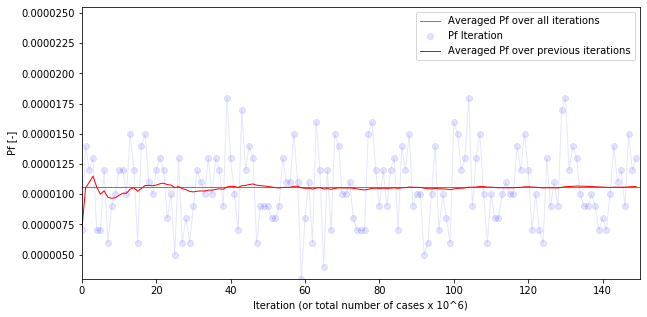

2.0437977982832195e-06


In [4]:
Pf = np.loadtxt("collected_data_overtopping.txt")
Pf_tot = []
x = np.arange(0, len(Pf), 1)
for i in range(len(Pf)):
    Pf_tot.append(np.sum(Pf[0:(i+1)])/(i+1))

plt.figure(figsize=[10,5])
plt.xlim(0,len(x))
plt.ylim(np.min(Pf),np.max(Pf)+(np.max(Pf)-np.min(Pf))*0.5)
plt.axhline(np.average(Pf), alpha=0.5, color='black', lw=1, label="Averaged Pf over all iterations")
plt.plot(x, Pf, color='blue', alpha=0.1, lw=1)
plt.plot(x, Pf, 'o', color='blue', alpha=0.1, label="Pf Iteration")
plt.plot(x, Pf_tot, color='red', lw=1, label="Averaged Pf over previous iterations")
plt.legend(loc='best')
plt.xlabel("Iteration (or total number of cases x 10^6)")
plt.ylabel("Pf [-]")
plt.show()
print(1/((150e6 * np.average(Pf)**0.5)))